In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
def identifying_assets():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    data = pd.read_html(url)
    table = data[0]
    top_100_tickers = table.head(104)['Symbol'].tolist()
    return top_100_tickers

In [4]:
# Class for calculating price momentum factors
class PriceMomentumCalculator:
    def __init__(self, data):
        self.data = data.tail(280).head(260)  
    def slope_52_week(self):
        return self.data.apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])

    def percent_above_260day_low(self):
        min_prices = self.data.min()
        last_prices = self.data.iloc[-1]
        return (last_prices - min_prices) / min_prices * 100

    def price_oscillator(self):
        mean_20 = self.data.tail(20).mean()
        overall_mean = self.data.mean()
        return (mean_20 - overall_mean) / overall_mean * 100

In [5]:
# Function for calculating 39-week return
def _39week_return(data):
    recent_data = data.tail(299).head(195)
    return (recent_data.iloc[-1] - recent_data.iloc[0]) / recent_data.iloc[0] * 100

In [6]:
# Class for asset selection
class AssetSelection:
    def __init__(self, data, pm_calculator, volume_data):
        self.data = data
        self.pm_calculator = pm_calculator
        self.volume_data = volume_data

    def volume_price_trend(self):
        price_data = self.data.tail(272).head(255)
        vol_data = self.volume_data.tail(272).head(255)
        return ((price_data.diff() * vol_data).cumsum()).iloc[-1]

    def select_assets(self):
        scores = pd.DataFrame({
            'slope_52_week': self.pm_calculator.slope_52_week(),
            'percent_above_260day_low': self.pm_calculator.percent_above_260day_low(),
            'price_oscillator': self.pm_calculator.price_oscillator(),
            'week_39_return': _39week_return(self.data),
            'volume_price_trend': self.volume_price_trend()
        })

        combined_scores = scores.mean(axis=1)
        sorted_scores = combined_scores.sort_values(ascending=False)

        long_basket = sorted_scores.head(15).index.tolist()
        short_basket = sorted_scores.tail(15).index.tolist()

        return long_basket, short_basket


In [7]:
class Backtest:
    def __init__(self, data, volume_data, asset_selector):
        self.data = data
        self.volume_data = volume_data
        self.asset_selector = asset_selector

    def calculate_monthly_returns(self, start_date, end_date):
        # Select assets for portfolio
        long_basket, short_basket = self.asset_selector.select_assets()

        # Calculate monthly returns for the selected period
        monthly_data = self.data.loc[start_date:end_date]
        monthly_returns_data = monthly_data.pct_change().dropna()

        # Equal weighting for simplicity
        long_weight = 1 / len(long_basket) if long_basket else 0
        short_weight = -1 / len(short_basket) if short_basket else 0

        long_return = short_return = etf_return = 0
        if not monthly_returns_data.empty:
            if long_basket:
                long_return = (monthly_returns_data[long_basket] * long_weight).sum(axis=1).iloc[-1]
            if short_basket:
                short_return = (monthly_returns_data[short_basket] * short_weight).sum(axis=1).iloc[-1]
            total_return = long_return + short_return

            # Calculate ETF return for the same period
            etf_return = monthly_data.mean(axis=1).pct_change().dropna().iloc[-1]

            return total_return, long_return, short_return, etf_return
        return 0, 0, 0, 0  # No returns for empty data

    def backtest_portfolio(self):
        results = []

        for month_end in pd.date_range(start=self.data.index.min(), end=self.data.index.max(), freq='M'):
            month_start = month_end - pd.offsets.MonthBegin(1)
            total_return, long_return, short_return, etf_return = self.calculate_monthly_returns(month_start, month_end)

            results.append({
                'date': month_end,
                'total_return': total_return,
                'long_return': long_return,
                'short_return': short_return,
                'etf_return': etf_return
            })

        return pd.DataFrame(results)

In [8]:
# Identifying assets (SPY tickers)
spy_tickers = identifying_assets()
Data = yf.download(spy_tickers, period='5y')['Adj Close']
Volume_Data = yf.download(spy_tickers, period='5y')['Volume']

# Cleaning data
Data = Data.drop(columns=['BF.B', 'BRK.B'], errors='ignore').dropna(axis=1)
Volume_Data = Volume_Data.dropna(axis=1)
Data.index = pd.to_datetime(Data.index)

# Initialize calculators and selectors
pm_calculator = PriceMomentumCalculator(Data)
asset_selector = AssetSelection(Data, pm_calculator, Volume_Data)

# Initialize and run backtester
backtester = Backtest(Data, Volume_Data, asset_selector)
backtest_results = backtester.backtest_portfolio()




[*********************100%%**********************]  104 of 104 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=5y)')



[*********************100%%**********************]  104 of 104 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=5y)')


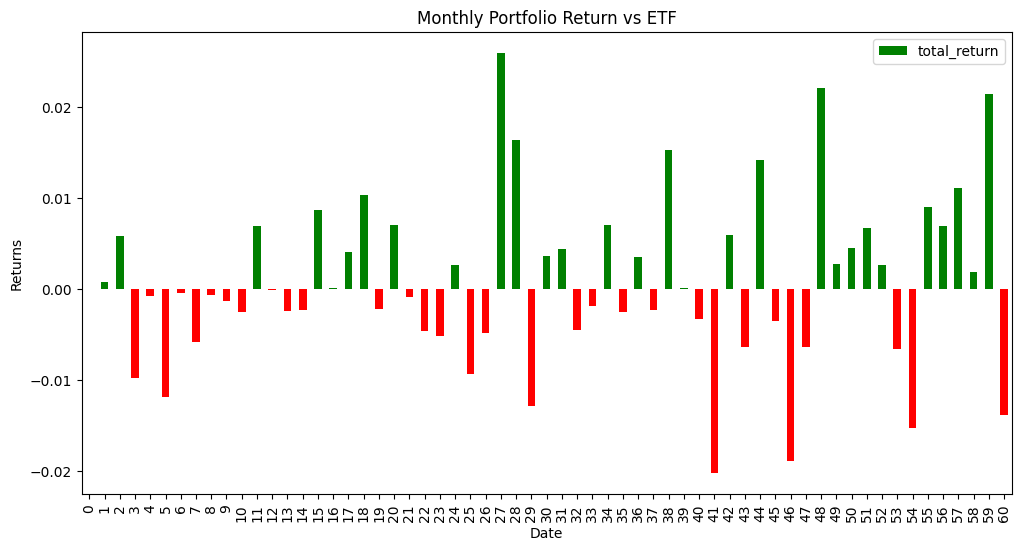

In [9]:
backtest_results['monthly_etf_return'] = backtest_results['etf_return'].cumsum()

plt.figure(figsize=(12, 6))
backtest_results['total_return'].plot(kind='bar', color=backtest_results['total_return'].apply(lambda x: 'g' if x >= 0 else 'r'))
plt.title('Monthly Portfolio Return vs ETF')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()



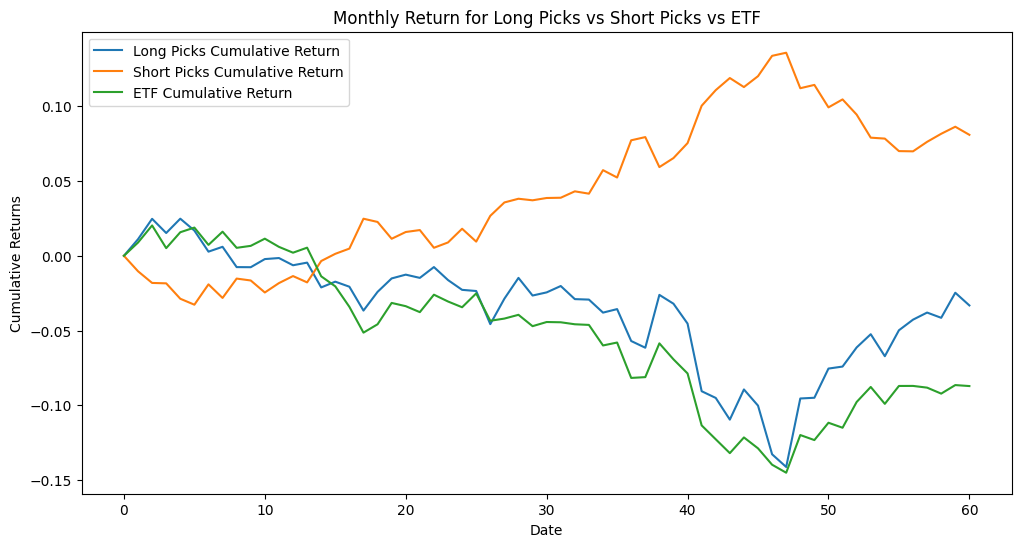

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['long_return'].cumsum(), label='Long Picks Cumulative Return')
plt.plot(backtest_results['short_return'].cumsum(), label='Short Picks Cumulative Return')
plt.plot(backtest_results['monthly_etf_return'], label='ETF Cumulative Return')
plt.title('Monthly Return for Long Picks vs Short Picks vs ETF')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


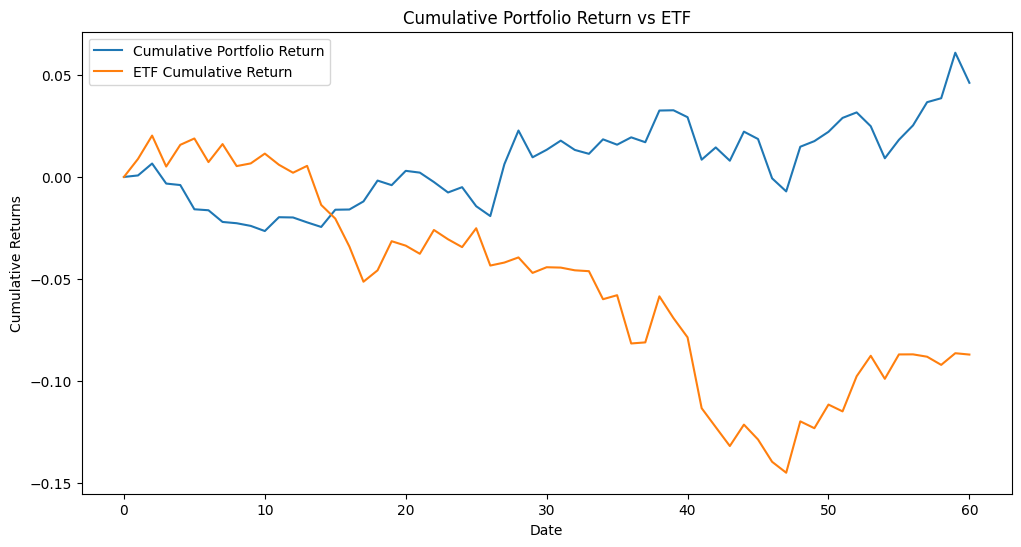

In [11]:
backtest_results['cumulative_portfolio_return'] = (1 + backtest_results['total_return']).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(backtest_results['cumulative_portfolio_return'], label='Cumulative Portfolio Return')
plt.plot(backtest_results['monthly_etf_return'], label='ETF Cumulative Return')
plt.title('Cumulative Portfolio Return vs ETF')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
